In [16]:
import torch
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
# data=np.load("CSI-02-0006/UMA4Rx32Tx5Ms8RB30km.npy")
# new_shape = (21000, 20, 2 * 32 * 4 * 8)
# data = data.reshape(new_shape)

In [21]:
import h5py

file_path="./dbig.mat"
# Load the .mat file as an HDF5 file
with h5py.File(file_path, 'r') as file:
    # List all the group/dataset names contained within the file
    keys = list(file.keys())

    # To understand the structure, we'll explore the dimensions of datasets within the first group/key
    data_shapes = {key: file[key].shape for key in keys}

data_shapes
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
with h5py.File(file_path, 'r') as file:
    data = np.array(file['input_channel'])

In [3]:
data.shape

(21000, 20, 2048)

In [4]:
X = data[:, :-1, :]  # Use all time steps except the last as input
y = data[:, -1, :]   # Use the last time step as the target

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
# Reshape the data for normalization: (num_samples * num_timesteps, num_features)
num_samples, num_timesteps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)
X_test_reshaped = X_test.reshape(-1, num_features)



In [6]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
X_train_normalized = scaler.fit_transform(X_train_reshaped)
X_test_normalized = scaler.transform(X_test_reshaped)



In [7]:
# Reshape the data back to original (21000, 19, 2048)
X_train = X_train_normalized.reshape(num_samples, num_timesteps, num_features)
X_test = X_test_normalized.reshape(X_test.shape[0], num_timesteps, num_features)

In [14]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((16800, 19, 2048), (4200, 19, 2048), (16800, 2048), (4200, 2048))

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Assuming you have already prepared and split your data into X_train, X_test, y_train, y_test
# and your data is normalized as shown in the previous messages

# Model architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(2048))  # Assuming you are predicting 2048 features at the next time step

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)


Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 1.2415e-04 - val_loss: 1.2506e-05
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.1434e-05 - val_loss: 9.5132e-06
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 9.6324e-06 - val_loss: 8.8878e-06
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 9.0678e-06 - val_loss: 8.6331e-06
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 9.0911e-06 - val_loss: 8.4089e-06
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 8.7349e-06 - val_loss: 8.3956e-06
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 8.5764e-06 - val_loss: 8.1672e-06
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 8.2875e-06 - val_loss: 8.1602e-06
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 8.2852e-06 - val_loss: 8.0356e-06
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 8.1161e-06 - val_loss: 7.9089e-06


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
predictions = model.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) 

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Mean Squared Error (MSE): 8.421819e-06
Root Mean Squared Error (RMSE): 0.002902037
Mean Absolute Error (MAE): 0.0020047675


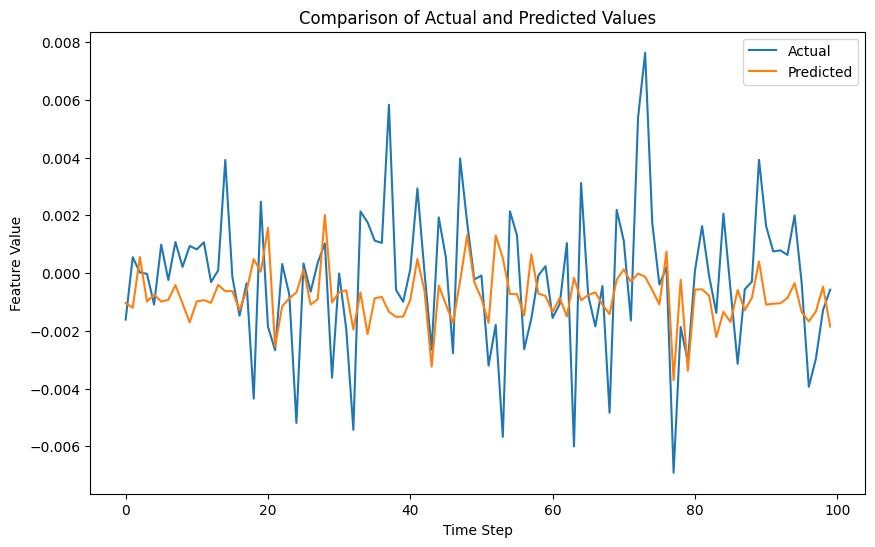

In [26]:
import matplotlib.pyplot as plt

feature=42
# Example: Plotting the actual vs predicted values for the first feature across all time steps in the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test[:100, feature], label='Actual')
plt.plot(predictions[:100, feature], label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Feature Value')
plt.legend()
plt.show()


In [27]:
from sklearn.metrics import r2_score

# Calculate R^2 for each feature
r2_scores = [r2_score(y_test[:, i], predictions[:, i]) for i in range(y_test.shape[1])]

# Calculate the mean R^2 score across all features for an overall performance metric
mean_r2_score = np.mean(r2_scores)

print("Mean R^2 Score:", mean_r2_score)


Mean R^2 Score: 0.04947715620637457


In [28]:
# Assuming `predictions` are your model's predictions and `y_test` are the actual values

# Calculate the absolute percentage error for each prediction
percentage_errors = np.abs((predictions - y_test) / y_test) * 100

# Define the threshold for an accurate prediction (e.g., error within 10%)
accuracy_threshold = 10  # 10%

# Calculate the percentage of predictions that are within the accuracy threshold
accurate_predictions = np.sum(percentage_errors < accuracy_threshold, axis=1) / y_test.shape[1]
overall_accuracy = np.mean(accurate_predictions) * 100

print(f"Overall 'accuracy': {overall_accuracy:.2f}%")

Overall 'accuracy': 2.58%
